<a href="https://colab.research.google.com/github/bastamova/python-excersies/blob/master/hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U scikit-learn > None

In [3]:
!pip install --upgrade matplotlib > None

In [67]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [7]:
data = pd.read_csv('WineQT.csv')
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
# Удалим дублируещиеся данные
data.drop_duplicates(keep=False,inplace=True)
str=data.duplicated().sum()
print(f'Number of duplicates: {str}')

Number of duplicates: 0


In [9]:
# Определим распределение данных по шкале оценки
data['quality'].value_counts()

quality
5    387
6    362
7    102
4     33
8     14
3      6
Name: count, dtype: int64

Для изменения первоначальной шкалы оценки от 0 до 10 применим метод LabelEncoder, поскольку признак является ординальным. Таким образом, шкала оценки качества вина будет связана отношением порядка, в группу хороших вин будем включать объекты с оценкой от 3 включительно.

In [10]:
le = LabelEncoder()
data['quality']= le.fit_transform(data['quality'])
y= le.classes_
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,2
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,2


Сведем задачу бинарной классификации к отнесению вина в категорию 1 - хорошее вино с рейтингом >= 3 и 0 - плохое вино с рейтингом < 3.

In [11]:
# Зададим функцию, определяющую категорию вина
def good_vine(x):
  if x<3:
    return 0
  else:
    return 1
data['good_quality']=data['quality'].apply(good_vine)

In [12]:
data['good_quality'].value_counts()

good_quality
1    478
0    426
Name: count, dtype: int64

In [ ]:
# Зададим входные переменные и таргетированную переменную
x = data.iloc[:,0:11].values
y = data['good_quality'].values
print(y)

In [14]:
# Разобьем датасет на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2024, test_size=0.25)

In [15]:
# Проведем стандартизацию данных
sc = StandardScaler()
X_train_std = sc.fit_transform(x_train)
X_test_std = sc.fit_transform(x_test)

# Логистическая регресия

Применим модель логистичекой регрессии, поскольку переменная target принимает категориальное значение: хорошее вино(1) или плохое(0).

In [16]:
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)
y_preds_logreg = logreg.predict(X_test_std )
print(classification_report(y_test, y_preds_logreg))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       104
           1       0.77      0.79      0.78       122

    accuracy                           0.76       226
   macro avg       0.76      0.76      0.76       226
weighted avg       0.76      0.76      0.76       226



Accuracy= 0.76 показывает достаточно высокое значение, однако, данная метрика не учитывает дисбаланс классов.

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
model_matrix= confusion_matrix(y_test, y_preds_logreg, labels=[1,0])
model_matrix_df=pd.DataFrame(model_matrix)
model_matrix_df

,0,1
0,96,26
1,28,76


Измерим качество модели при помощи метрики AUC-ROC.

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
def plot_roc_auc(fpr, tpr, thresholds, title):
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Logistic')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid()
  plt.show()

In [22]:
print(roc_auc_score(y_test, logreg.predict_proba(X_test_std)[:, 1]))

0.8278688524590163


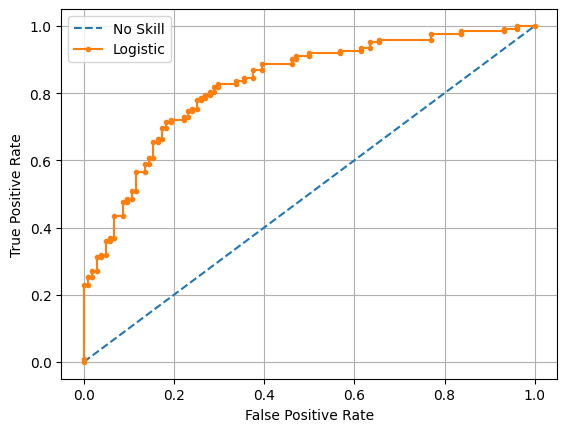

In [32]:
# Отобразим кривую ROC
y_pred= logreg.predict_proba(X_test_std )[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='Logistic regression')

Вывод: модель работает довольно неплохо. Изгиб кривой и ее расположение по отношению к диагональной прямой показывают, что модель в целом эффективна. Качество модели также значительно улучшила стандартизация даннных.

# KNN

In [62]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_std, y_train)
y_preds_knn = knn.predict(X_test_std)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       104
           1       0.72      0.77      0.75       122

    accuracy                           0.72       226
   macro avg       0.72      0.71      0.71       226
weighted avg       0.72      0.72      0.72       226



In [63]:
print(roc_auc_score(y_test, knn.predict_proba(X_test_std)[:, 1]))

0.7775457124842371


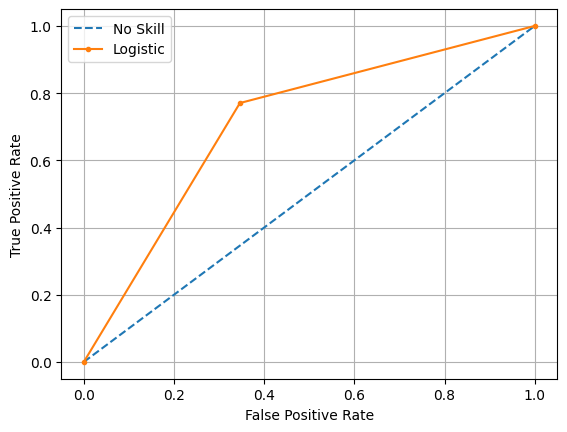

In [44]:
y_pred= knn.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_preds_knn)
plot_roc_auc(fpr, tpr, thresholds, title='KNeighborsClassifier')

In [64]:
knn = KNeighborsClassifier(n_neighbors=17, weights='distance')
knn.fit(X_train_std, y_train)
y_preds_knn = knn.predict(X_test_std)
print(roc_auc_score(y_test, knn.predict_proba(X_test_std)[:, 1]))

0.8335435056746533


Вывод: модель KNN при выборе 5 соседей работает хуже, чем модель логистической регрессии. При 17 соседях качество модели даже слегка превышает качество модели логистической регрессии, но модель становится менее гибкой.